Importing libraries

In [1]:
#introducing libraries
!pip install numpy scipy pandas>1.0 matplotlib lmfit colour
#calling up libraries
from datetime import datetime
import pandas as pd
import numpy as np
import scipy
from scipy import optimize
import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.stats import linregress
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from mpl_toolkits import mplot3d
from datetime import timedelta
from lmfit.models import LorentzianModel
import statistics
from matplotlib.collections import LineCollection 
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.signal import argrelmax
#import CSV data from drive
from google.colab import drive
import glob
import os
drive.mount('drive', force_remount=True)
folder = "/content/drive/MyDrive/P3HT;PCBM/Group import/"
all_files = glob.glob(os.path.join(folder, '*.csv'))
Spec_data = {}
Sorb_data = {}
Irr_data = {}
titles = []



for filename in all_files:
  #Simplify name
  new_name = filename.replace(".csv", "").replace("/content/drive/MyDrive/P3HT;PCBM/Group import/","")
  #import data
  df = pd.read_csv(filename, sep=',', header=0)

  #Some cleaning
  df = df.rename({'0.00000E+0.1':'0.000000000'}, axis=1)
  cols = df.columns.values
  cols[0] = 'Wavelength(nm)'
  df.columns = cols
  #remove extraneous data at the end
  df = df[pd.to_numeric(df['Wavelength(nm)'], errors='coerce').notnull()]
  df['Wavelength(nm)'] = df['Wavelength(nm)'].astype(float)
  df = df.set_index('Wavelength(nm)')
  #remove rows (wavelengths) with at least 3 na values
  df = df.dropna(axis=0, thresh=3)

  #change strings to numbers
  df = df.astype(float)
  df.columns = np.around(pd.to_numeric(df.columns), 3)

  titles.append(new_name)
  Spec_data[new_name] = df

Spec_data



Mounted at drive


{'P3HT neat film bhj .7mW ChlBnz 20min run1 UV-Vis (corrected)':                 -5.182     -4.932     ...   6623.220   6999.820
 Wavelength(nm)                        ...                      
 335.695               NaN        NaN  ...  -0.000207   0.000030
 336.268               NaN        NaN  ...  -0.000088  -0.000219
 336.841               NaN        NaN  ...  -0.000004  -0.000005
 337.413               NaN        NaN  ...   0.000328  -0.000246
 337.986               NaN        NaN  ...   0.000301  -0.000259
 ...                   ...        ...  ...        ...        ...
 825.485               NaN  -0.000305  ...   0.001131   0.001159
 826.090               NaN   0.000897  ...   0.001883   0.000331
 826.695               NaN  -0.000002  ...  -0.000385   0.000748
 827.300               NaN   0.000568  ...  -0.000861   0.000107
 827.905         -0.000264   0.000614  ...   0.000560        NaN
 
 [837 rows x 166 columns],
 'P3HT-PCBM NPs agg film 9800uW NIR (corrected)':             

In [2]:
#routine for switching between type comparisons
def switch(name):
  if ('NPs' in name) and ('film' in name):
    return 'Blend Nanoparticles in Annealed Film'
  elif ('sol' in name) and ('NPs' in name):
    return 'Blend Nanoparticles in Solution'
  elif ('bhj' in name) and ('film' in name):
    k = name.split(sep=' ')[0]
    return k + ' in Bulk Annealed Film'
  else:
    return ' '

f=10000
#for excitations, hc needs to be in uJ*nm
hc = 1.98644586*(10**(-10))
pump_wl = 400
OD = 0.4
beam_area = 3.1415926536*(0.01**2)

def fluence_translate(name):
  #note units are uJ/cm^2
  P = 0
  words = name.split()
  for word in words:
    if ('uW' in word):
      P = float(word.replace('uW', ''))
    if ('mW' in word):
      P = 1000*float(word.replace('mW',''))
  photon_E = hc/pump_wl
  photons_absorbed = 1 - (10**(-OD))
  #Excitation Density
  #return photons_absorbed*P*0.8/(f*photon_E*beam_area)
  #E per pulse per area
  return P/(f*beam_area)




for name in Spec_data:
  print(fluence_translate(name))


222.81692032792952
0.0
0.0
7.639437268386155
31.830988618275647
146.74085753025074
311.94368845910134
3119.4368845910135
6.366197723655129
31.830988618275647
159.15494309137824
311.94368845910134
3087.6058959727375
311.94368845910134
3119.4368845910135


Importing data from google drive folder, sorting each into absorbance, spectroscope runs, and general spectroscope data.

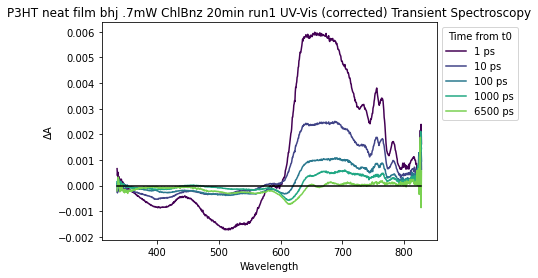

P3HT neat film bhj .7mW ChlBnz 20min run1 UV-Vis (corrected)


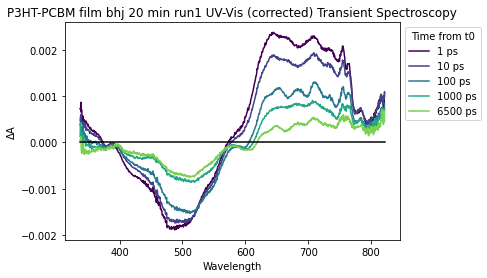

P3HT-PCBM film bhj 20 min run1 UV-Vis (corrected)


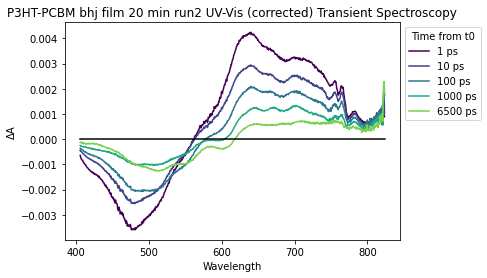

P3HT-PCBM bhj film 20 min run2 UV-Vis (corrected)


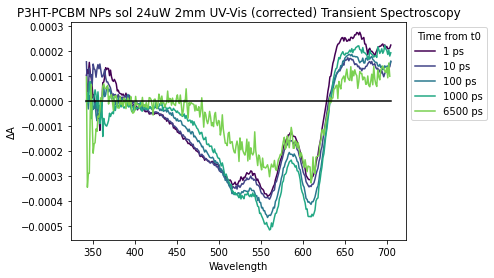

P3HT-PCBM NPs sol 24uW 2mm UV-Vis (corrected)


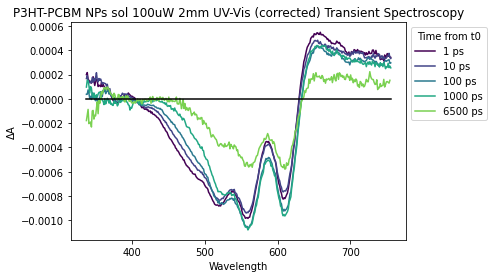

P3HT-PCBM NPs sol 100uW 2mm UV-Vis (corrected)


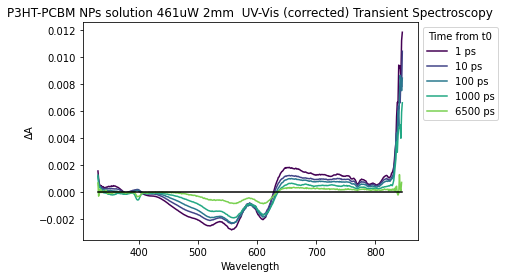

P3HT-PCBM NPs solution 461uW 2mm  UV-Vis (corrected)


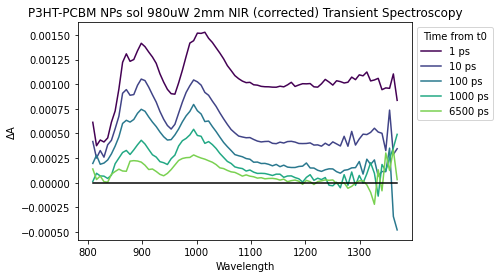

P3HT-PCBM NPs sol 980uW 2mm NIR (corrected)


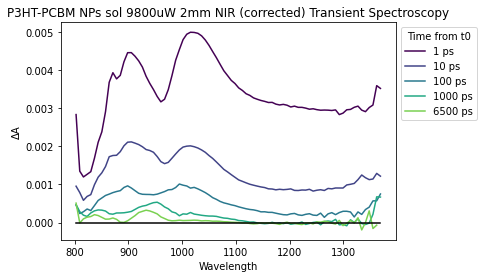

P3HT-PCBM NPs sol 9800uW 2mm NIR (corrected)


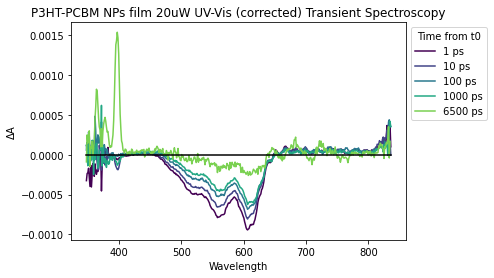

P3HT-PCBM NPs film 20uW UV-Vis (corrected)


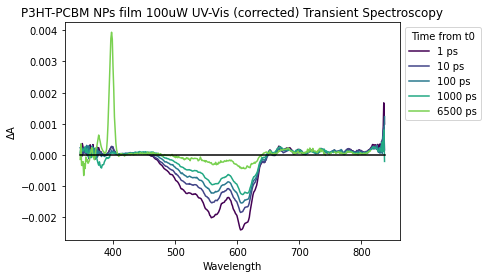

P3HT-PCBM NPs film 100uW UV-Vis (corrected)


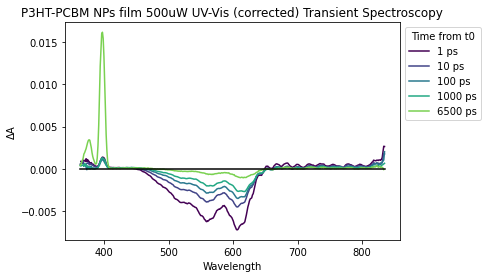

P3HT-PCBM NPs film 500uW UV-Vis (corrected)


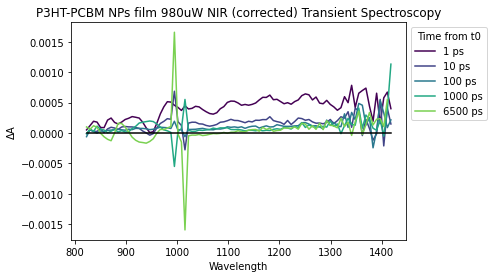

P3HT-PCBM NPs film 980uW NIR (corrected)


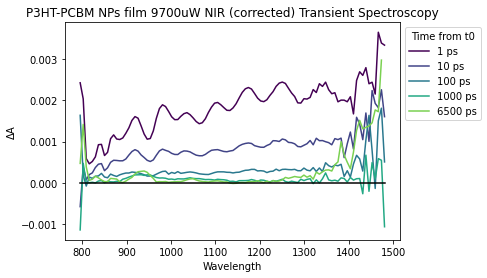

P3HT-PCBM NPs film 9700uW NIR (corrected)


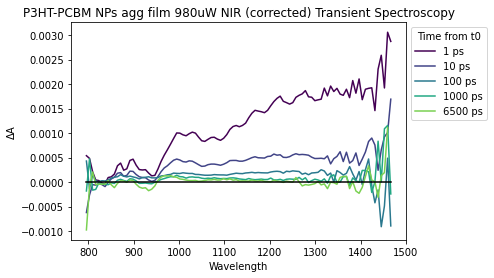

P3HT-PCBM NPs agg film 980uW NIR (corrected)


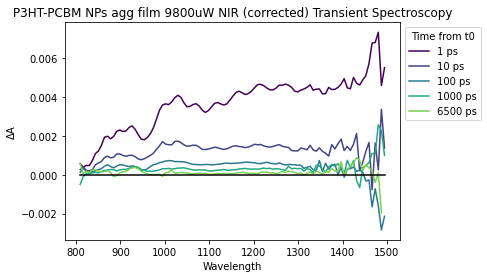

P3HT-PCBM NPs agg film 9800uW NIR (corrected)


In [3]:
def spec_time_data(data, name, times):
  plt.subplots()
  for i in range(len(times)):
      plt.plot(np.asarray(data[name].index), np.asarray(data[name][times[i]]),  label=str(dex[i])+' ps', color=colormap(i/len(times)))
      plt.legend(title='Time from t0', bbox_to_anchor=(1,1), loc="upper left")
      plt.title(name + " Transient Spectroscopy")
      plt.xlabel('Wavelength')
      plt.ylabel('ΔA')
#color method from stack exchange :https://stackoverflow.com/questions/25668828/how-to-create-colour-gradient-in-python
#def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
#    c1=np.array(mpl.colors.to_rgb(c1))
#    c2=np.array(mpl.colors.to_rgb(c2))
#    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)
#c1='white' 
#c2='black' 
#better color method
colormap = cm.get_cmap('viridis')
#find global maxes to fix TA scale

bmaxes=[]
bmins=[]

for name in Spec_data:
  bmaxes.append(Spec_data[name].max().max())
  bmins.append(Spec_data[name].min().min())

bmax = max(bmaxes)
bmin = min(bmins)

#https://codereview.stackexchange.com/questions/189319/nearest-neighbor-algorithm-general-neares
def find_nearest(array, number, direction): 
    idx = -1
    if direction is None:
        idx = (np.abs(array - number)).min()
    elif direction == 'backward':
        _delta = number - array
        _delta_positive = _delta[_delta > 0]
        if not _delta_positive.empty:
            idx = _delta_positive.min()
    elif direction == 'forward':
        _delta = array - number
        _delta_positive = _delta[_delta >= 0]
        if not _delta_positive.empty:
            idx = _delta_positive.min()
    return idx

#filling 'times' list with closest values found in time stamps (columns)
for name in Spec_data:
  dex = [1, 10, 100, 1000, 6500]
  times = []
  for i in range(len(dex)):
    times.append(np.around(find_nearest(Spec_data[name].columns,dex[i], 'forward')+dex[i], 3))
  spec_time_data(Spec_data, name, times)
  plt.plot(np.array(Spec_data[name].index), np.zeros(len(Spec_data[name].index), dtype=float, order='C'), color='black')
  plt.show()


  print(name)
  plt.show()




/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


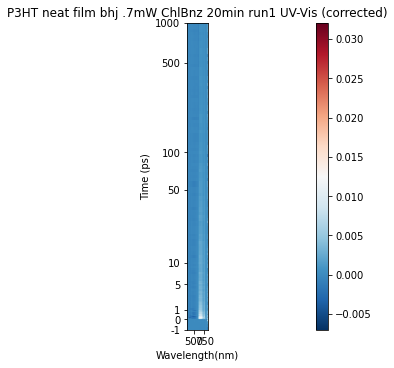

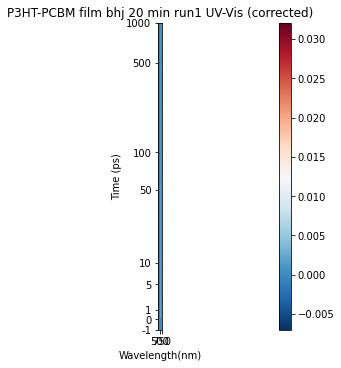

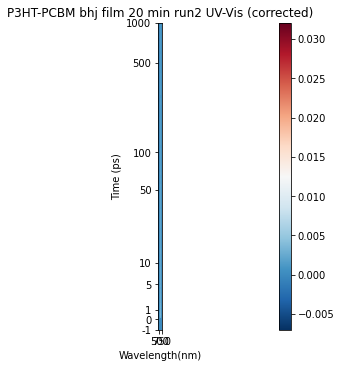

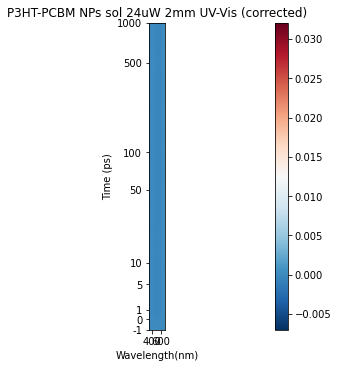

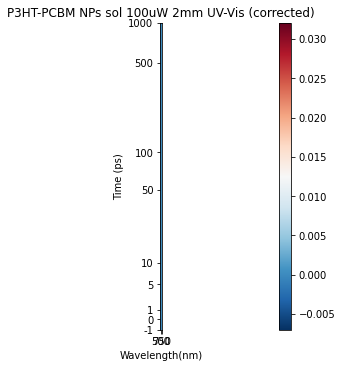

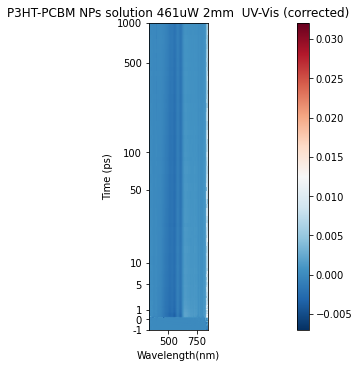

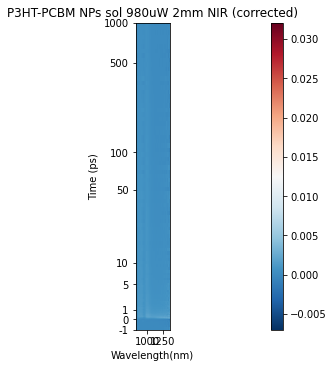

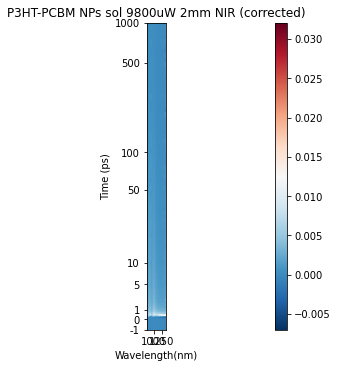

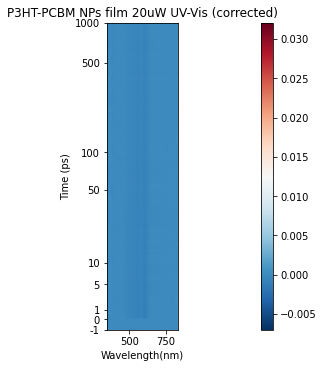

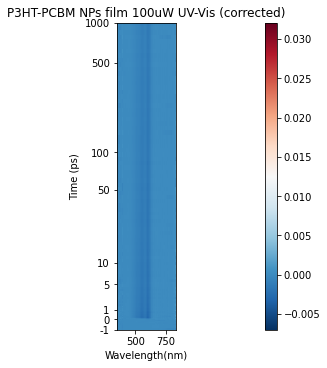

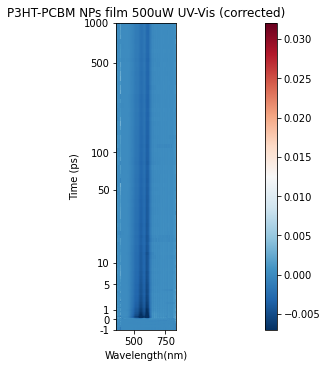

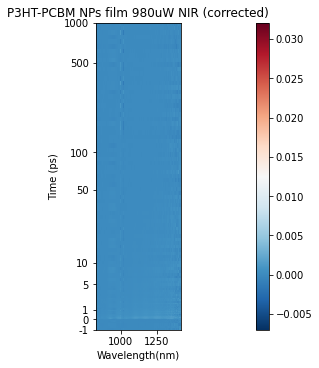

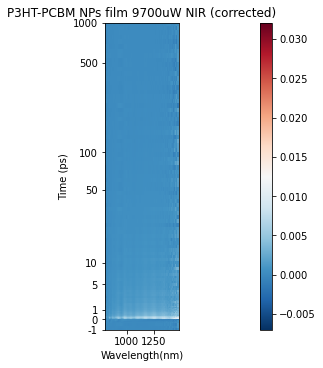

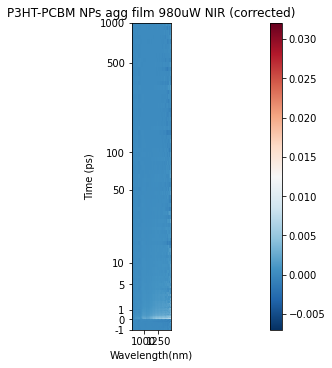

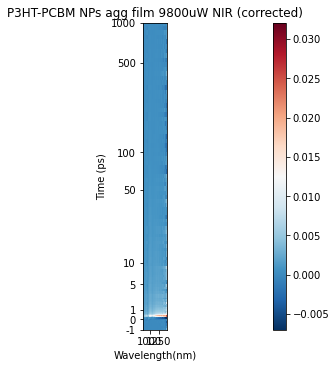

In [4]:
#method from mathplotlib documentation

viridis = cm.get_cmap('RdBu_r', 1000)
def plot_examples(colormaps, data, name):
    """
    Helper function to plot data with associated colormap.
    """
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 5),
                            constrained_layout=True, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data.index,np.log10(data.columns+6), data.T, cmap=cmap, rasterized=True, vmin=0.7*bmin, vmax=bmax)
        fig.colorbar(psm, ax=ax)
        ax.title.set_text(name)
    yvals = np.asarray([-1, 0, 1, 5, 10, 50, 100, 500, 1000])
    ylogs = np.around(np.log10(yvals + 6), 2)
    plt.ylim(ylogs[0], ylogs[-1])
    plt.yticks(ylogs, labels=yvals)  

    plt.xlabel('Wavelength(nm)')
    plt.ylabel('Time (ps)')
for name in Spec_data:
  Spec_data[name] = (Spec_data[name].T).interpolate().T

  plot_examples([viridis], Spec_data[name], name)
  plt.show()


Try adding again?

In [5]:
#method from mathplotlib documentation

viridis = cm.get_cmap('coolwarm', 100)
def plot_comparison(colormaps, data):
    """
    Helper function to plot data with associated colormap.
    """
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            constrained_layout=True, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data.index,np.log10(data.columns+6), data.T, cmap=cmap, rasterized=True, vmin=-0.01, vmax=0.01)
        fig.colorbar(psm, ax=ax)
        ax.title.set_text(name)
    plt.xlim(0.9,3.0)
    yvals = np.asarray([-5, -1, 0, 1, 5, 10, 50, 100, 500, 1000, 4000])
    ylogs = np.around(np.log10(yvals + 6), 2)
    plt.yticks(ylogs, labels=yvals)


    plt.xlabel('Wavelength(nm)')
    plt.ylabel('Time (ps)')
    plt.show()



0.26901369703769257


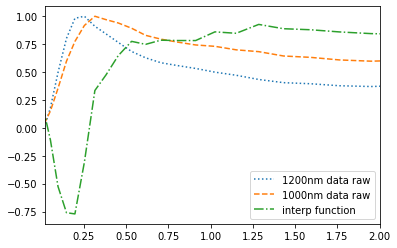

0.2561895223488348


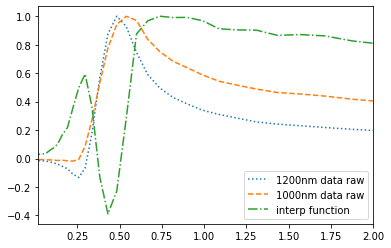

0.15578754734684486


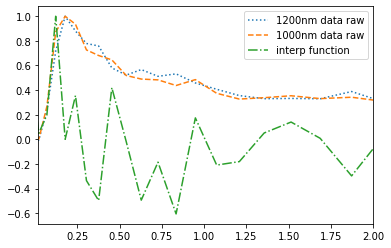

0.06619119639622352


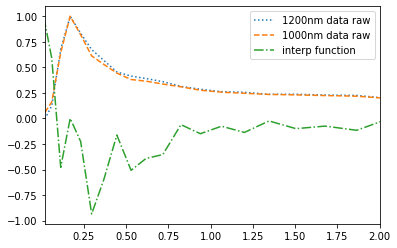

0.06696462109664574


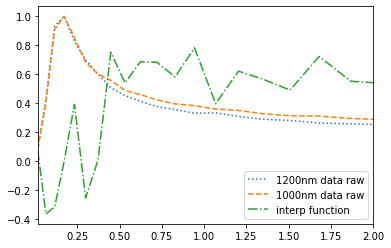

0.1213433783399142


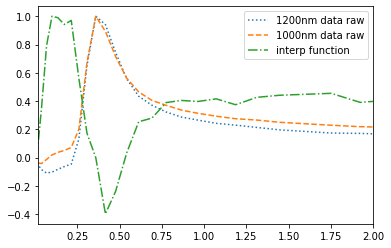

In [42]:


#check kinetic algorithm works
for name in Spec_data:
  if 'NIR' in name:
    test = Spec_data[name]
    x1, y1 = averaged_kinetics_raw(test, 1200)
    x2, y2 = averaged_kinetics_raw(test, 1000)
    plt.plot(x1, y1, label='1200nm data raw', linestyle=':')
    plt.plot(x2, y2, label='1000nm data raw', linestyle='--')
    f = interp1d(x2, y2)
    y_approx = f(x1)
    y_sub = y_approx - y1
    val = np.nanmax(y_sub)
    print(val)

    plt.plot(x1, y_sub/val, label='interp function', linestyle='-.')
    plt.xscale('linear')
    plt.xlim(0.02, 2)
    plt.legend()
    plt.show()





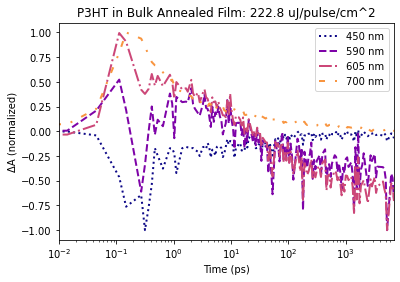

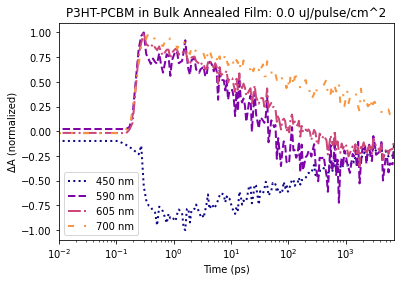

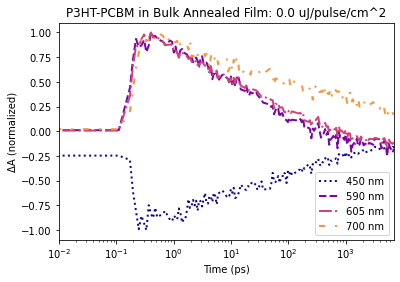

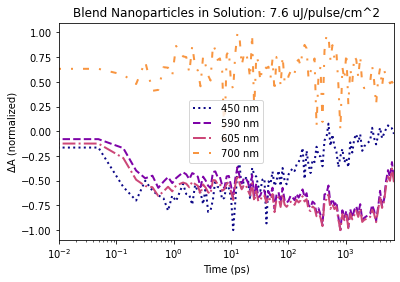

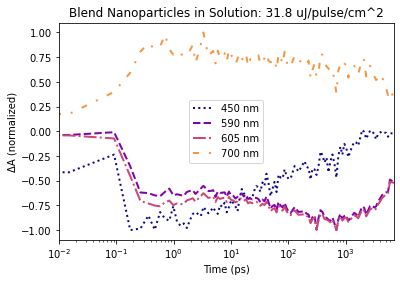

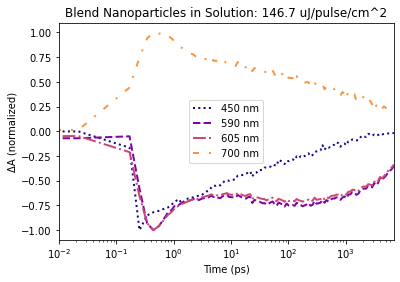

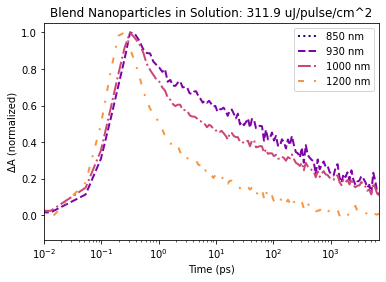

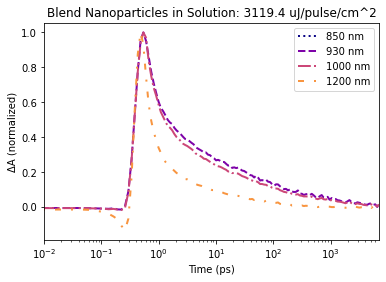

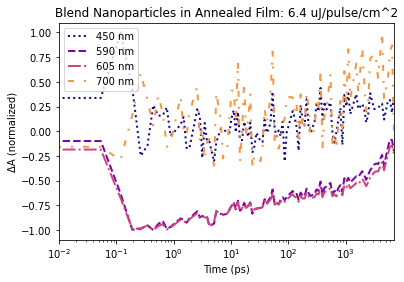

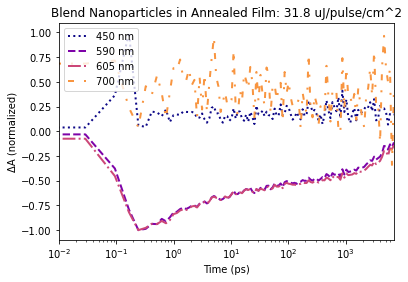

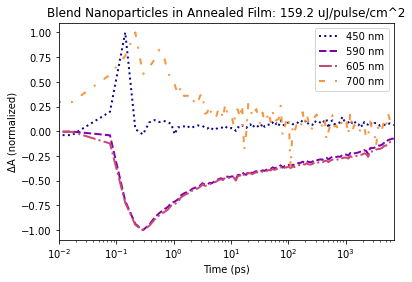

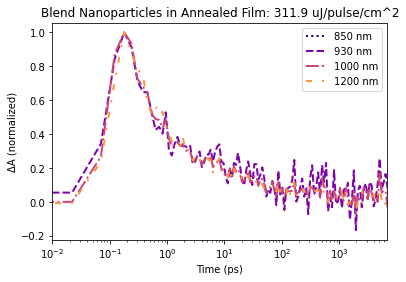

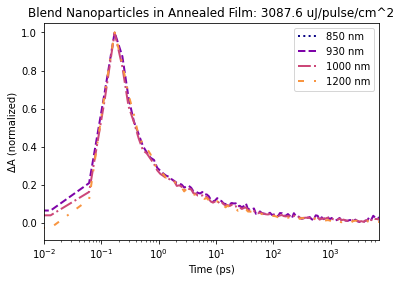

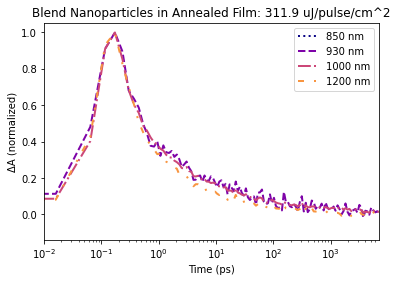

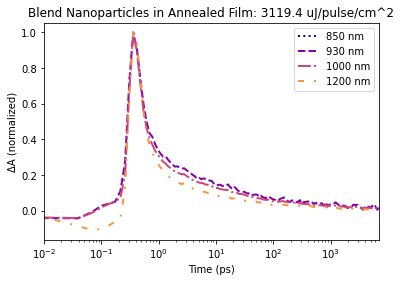

In [8]:
#Kinetic algorithm
WLs_of_interest = [450, 590, 605, 700, 850, 930, 1000, 1200]
WL_UV = sorted(i for i in WLs_of_interest if i <= 800)
WL_NIR = sorted(i for i in WLs_of_interest if i > 800)

def find_nearest_dex(array, number, direction=None): 
    idx = -1
    if direction is None:
        ser = np.abs(array-number)
        idx = ser.get_loc(ser.min())
    elif direction == 'backward':
        _delta = number - array
        _delta_positive = _delta[_delta > 0]
        if not _delta_positive.empty:
            idx = _delta.get_loc((_delta_positive.min()))
    elif direction == 'forward':
        _delta = array - number
        _delta_positive = _delta[_delta >= 0]
        if not _delta_positive.empty:
            idx = _delta.get_loc(_delta_positive.min())
    return idx
colormap = cm.get_cmap('plasma')
styles = [':', '--', '-.', (0, (3, 5, 1, 5)), (0, (1, 10)), (0, (1, 1)), (0, (3, 10, 1, 10, 1, 10)), (0, (5, 1)), (0, (3, 10, 1, 10)), (0, (5, 5)),(0, (3, 1, 1, 1)),  (0, (1, 1))]
def k_chart(data, name, guess):
  dex = find_nearest_dex(data.index, guess)
  #dd = data.iloc[dex-10:dex+10].mean()
  #data2 = dd[dd.index>1]
  #data3 = dd[(dd.index>1) & (dd.index<10)]
  #data4 = dd[(dd.index>400) & (dd.index<4500)]
  #update = pd.DataFrame(data4, columns = ['vals'])
  #slope = linregress(np.asarray(data4.index), np.asarray(np.log10(abs(data4))))[0]
  #intercept = linregress(np.asarray(data4.index), np.asarray(np.log10(abs(data4))))[1]
  #stderr = linregress(np.asarray(data4.index), np.asarray(np.log10(abs(data4))))[4]
  #update['estimate'] = 10**(slope*update.index+intercept)
  #+" -- Slope: "+str(np.around(slope, 6))+ " Std Err: "+str(np.around(stderr,8))

  
  
  i = WLs.index(guess)
  label = str(guess)+' nm'

  peak_to_norm =  data.iloc[dex-10:dex+10].mean().max()
  trough_to_norm = data.iloc[dex-10:dex+10].mean().min()
  norm = max(abs(peak_to_norm), abs(trough_to_norm))
  x = np.asarray(data.columns)
  y = np.asarray(data.iloc[dex-10:dex+10].mean())/norm
  plt.plot(x,y, label=label, linewidth=2, color=colormap(i/len(WLs)), linestyle=styles[i])
  #plt.plot(np.asarray(update.index), np.asarray(update['estimate']), linewidth=0.8, color='black')
  plt.ylabel('ΔA (normalized)')
  plt.yscale('linear')
  plt.xscale('log')
  plt.xlim(0.01,6900)
  plt.xlabel('Time (ps)')
def k_chart_bk(data, guess, label):
  f,(ax,ax2) = plt.subplots(1,2,sharey=True, facecolor='w')

  # plot the same data on both axes
  ax.plot(x, y)
  ax2.plot(x, y)

  ax.set_xlim(0,7.5)
  ax2.set_xlim(40,42.5)

  # hide the spines between ax and ax2
  ax.spines['right'].set_visible(False)
  ax2.spines['left'].set_visible(False)
  ax.yaxis.tick_left()
  ax.tick_params(labelright='off')
  ax2.yaxis.tick_right()

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

  d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
  kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
  ax.plot((1-d,1+d), (-d,+d), **kwargs)
  ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

  kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
  ax2.plot((-d,+d), (1-d,1+d), **kwargs)
  ax2.plot((-d,+d), (-d,+d), **kwargs)

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'


for name in Spec_data:
  if 'UV-Vis' in name:
    WLs = WL_UV
  elif 'NIR' in name:
    WLs = WL_NIR
  for value in WLs:
    k_chart(Spec_data[name], name, value)
  title  = switch(name) + ': ' +str(np.around(fluence_translate(name), 1))+' uJ/pulse/cm^2'
  plt.title(title)
  plt.legend()
  plt.show()


**Note to self on Kinetics: Careful!** *Maybe use the raw data rather than the interpolated data. You don't want to change the curve via interpolation.*

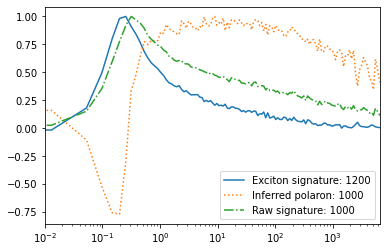

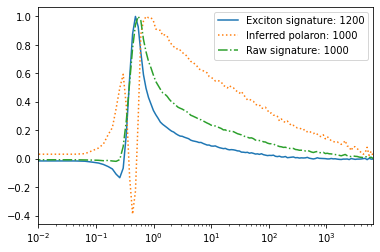

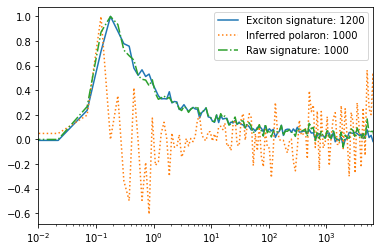

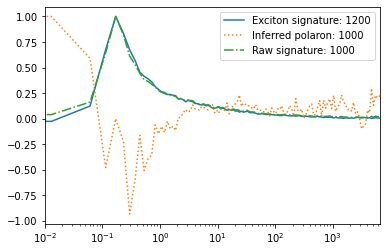

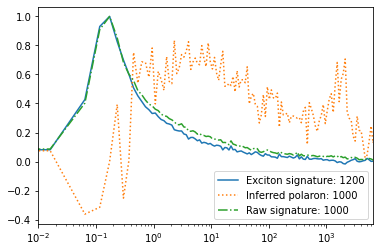

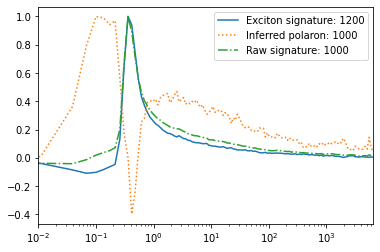

In [43]:
#Kinetics 2: Compare same WL at different fluences


#Kinetics 3: Create a function which subtracts normalized kinetics at one WL from another and plot it (e.g. remove P3HT exciton)
def averaged_kinetics_raw(data, guess):
  dex = find_nearest_dex(data.index, guess)
  peak_to_norm =  data.iloc[dex-10:dex+10].mean().max()
  trough_to_norm = data.iloc[dex-10:dex+10].mean().min()
  norm = max(abs(peak_to_norm), abs(trough_to_norm))
  if abs(trough_to_norm) > abs(peak_to_norm):
    norm = -1*norm
  x = np.asarray(data.columns)
  y = np.asarray(data.iloc[dex-10:dex+10].mean())/norm
  return x, y

def isolate_polaron(data, exc_wl, pol_wl):
  x_exc, y_exc = averaged_kinetics_raw(data, exc_wl)
  x_pol, y_pol = averaged_kinetics_raw(data, pol_wl)
  f = interp1d(x_pol, y_pol)
  y_pol_approx = f(x_exc)
  pol_sig = y_pol_approx - y_exc
  pol_sig_norm = pol_sig/np.nanmax(pol_sig)
  plt.plot(x_exc, y_exc, label = 'Exciton signature: ' + str(exc_wl), linestyle='-')
  plt.plot(x_exc, pol_sig_norm, label='Inferred polaron: ' +str(pol_wl), linestyle=':')
  plt.plot(x_pol, y_pol, label='Raw signature: '+str(pol_wl), linestyle='-.')
  plt.xscale('log')
  plt.xlim(0.01,6500)
  plt.legend()
  plt.show()

for name in Spec_data:
  if 'NIR' in name:
    data = Spec_data[name]
    isolate_polaron(data, 1200, 1000)




In [ ]:
hc = 1239.842
frame = pd.DataFrame(columns=['Solvent', 'Energy(eV)', 'Slope', 'Std Err', 'Material'])
def table_add(data, guess, name, scale):
  dex = find_nearest_dex(data.index, guess)
  dd = data.iloc[dex-10:dex+10].mean()
  if 'Acetone' not in fn.get(name):
    solvent = fn.get(name).split(' ')[0]
    material = fn.get(name).split(' ')[1]
  elif 'Acetone' in fn.get(name):
    solvent = fn.get(name).split(' ')[0]
    material = fn.get(name).split(' ')[2]
  if scale == 0:
    data4 = dd[(dd.index>1) & (dd.index<10)]
  if scale == 1:
    data4 = dd[(dd.index>10) & (dd.index<101)]
  if scale == 2:
    data4 = dd[(dd.index>400) & (dd.index<4500)]
  slope = linregress(np.asarray(data4.index), np.asarray(np.log10(abs(data4))))[0]
  stderr = linregress(np.asarray(data4.index), np.asarray(np.log10(abs(data4))))[4]
  return {'Solvent':solvent,'Energy(eV)':np.around(guess,2), 'Slope':slope, 'Std Err':stderr, 'Material':material}
for name in sorted(Spec_data):
  if int(name[0:2])%4 == 1:
    Es = switch(name, [hc/865 ,hc/934, hc/1150,hc/632, hc/585, hc/425,hc/1255 ,hc/898, hc/968, 1.77, 1.92], [hc/885 ,hc/934, hc/1150,1.96, 2.12, 2.92],[hc/1255 ,hc/898, hc/968, 1.77, 1.92])
    for value in Es:
      for name2 in sorted(Spec_data):
        if switch(name, 1, 2, 3) == switch(name2, 1, 2, 3):
          
          if value>=1.77 and "UvVis" in name2:
            dic = {'01':'01 CB blend ','02':'02 CF blend ','03':'03 OX blend ','04':'04 CSA blend','05':'05 CB PBDBT ','06':'06 CF PBDBT ','07':'07 OX PBDBT ','08':'08 CSA PBDBT','09':'09 CB ITIC 1','10':'10 CF ITIC 1','11':'11 OX ITIC 1','12':'12 CSA ITIC '}
            lab = dic.get(name2[0:2])
            frame = frame.append(table_add(abs(Spec_data[name2]), value, lab, 2), ignore_index=True)
          elif value<1.77 and 'UvVis' not in name2:
            frame = frame.append(table_add(abs(Spec_data[name2]), value, name2[0:12], 2), ignore_index=True)
frame = frame.set_index('Solvent')
frame = frame.sort_values(by=['Energy(eV)', 'Solvent'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(frame)